Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Epoch 1/100
18/18 [==============================] - 22s 1s/step - loss: 0.6942 - accuracy: 0.4911 - val_loss: 0.6918 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 19s 1s/step - loss: 0.6909 - accuracy: 0.5125 - val_loss: 0.6896 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 19s 1s/step - loss: 0.6881 - accuracy: 0.5786 - val_loss: 0.6871 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 19s 1s/step - loss: 0.6838 - accuracy: 0.5339 - val_loss: 0.6761 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 20s 1s/step - loss: 0.6736 - accuracy: 0.5714 - val_loss: 0.6769 - val_accuracy: 0.5468 - lr: 0.0010
Epoch 6/100
18/18 [==============================]

/tmp/ipykernel_32/1194738917.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (model.predict(test_images) >= 0.5).astype(np.int)


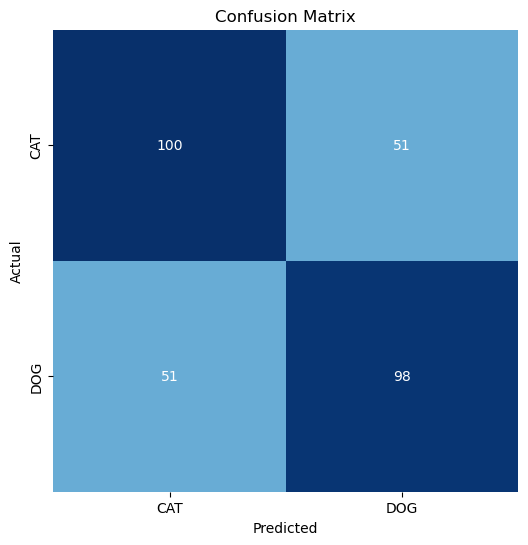

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.66      0.66      0.66       151
         DOG       0.66      0.66      0.66       149

    accuracy                           0.66       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.66      0.66      0.66       300



In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Set up image directory
img_directory = Path('../input/cat-and-dog-images-dataset/Dog and Cat .png')

# Get file paths and labels
file_paths = list(img_directory.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

# Create dataframe with file paths and labels
file_paths = pd.Series(file_paths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_data = pd.concat([file_paths, labels], axis=1)

# Split data into training and testing sets
train_data, test_data = train_test_split(image_data, train_size=0.7, shuffle=True, random_state=1)

# Data augmentation and normalization for training images
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

# Normalization for testing images
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Generate training, validation, and testing data flows
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Define the model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
training_history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

# Evaluate the model on the testing data
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# Make predictions on the testing data
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

# Compute confusion matrix and classification report
confusion_mtx = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
classification_rep = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

# Visualize confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", classification_rep)
